In [113]:
using JuMP, Gurobi, Ipopt,AmplNLWriter, NLopt
using Mosek, Cbc
    k = 3              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20
    T[3] = 40

    # define waypoints
    xw = [ 0.5   4  -6
           1.5   3  6]
   

    A = [1 0;
        -1 0;
        0 1;
        0 -1;]
    b = [xw[1,k] - 1.01; -(xw[1,k] + 1.01); xw[2,k] - 1.01; -(xw[2,k] + 1.01)]
   A = [1 0;
        -1 0;
        0 1;
        0 -1;]
   b = [1.5; -2.5; 1.5; -2.5];

In [145]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    @variable(m, x[1:2,1:T[k]])  # resulting position
    @variable(m, v[1:2,1:T[k]])  # resulting velocity
    @variable(m, u[1:2,1:T[k]])  # thruster input
    @variable(m, obstacle[1:4,1:T[k]], Bin)
    vMax = 0.5
    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== [0;0])

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end

    # hit all the waypoints
    for t in 1:T[k]-1
        @constraint(m, A*x[:,t] .<= b .+ 1000*obstacle[:,t])
        @constraint(m, sum(obstacle[i,t] for i in 1:4) <= 3)
    end
    for t in [1 k]
        @constraint(m, x[:,T[t]] .== xw[:,t])
    end

    for t in 1:T[k]
        @constraint(m, sum(v[:,t].^2) <= vMax)
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100
    β = 10
    @objective(m, Min, sum(u.^2) + λ*sum((x[:,T[2:k]]-xw[:,2:k]).^2) + β*sum((sum((v[:,t] .- vMax).^2 for t in 2:T[k]))))
    solve(m)
    xopt=getvalue(x)

2×40 Array{Float64,2}:
 0.5  0.5  0.654536  0.822041  …  -4.5732   -5.07631  -5.5735   -6.0
 1.5  1.5  1.63374   1.7787        5.52518   5.67382   5.82453   6.0

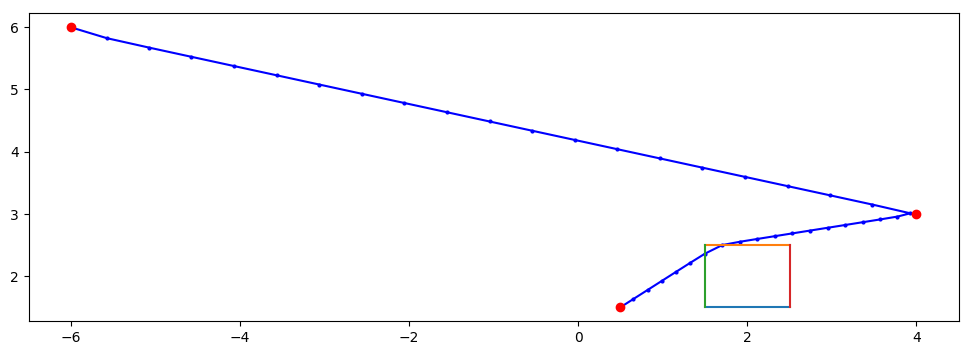

In [146]:
using PyPlot
figure(figsize=(12,4))
plot( xopt[1,:][:], xopt[2,:][:], "b.-", markersize=4 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )
plot(linspace(1.5,2.5,10),0.*linspace(1.5,2.5,10) .+ 1.5)
plot(linspace(1.5,2.5,10),0.*linspace(1.5,2.5,10) .+ 2.5)
plot(0.*linspace(1.5,2.5,10) .+ 1.5,linspace(1.5,2.5,10))
plot(0.*linspace(1.5,2.5,10) .+ 2.5,linspace(1.5,2.5,10));

In [147]:
getobjectivevalue(m)

273.9512400138865

In [148]:
xopt = (getvalue(x))

2×40 Array{Float64,2}:
 0.5  0.5  0.654536  0.822041  …  -4.5732   -5.07631  -5.5735   -6.0
 1.5  1.5  1.63374   1.7787        5.52518   5.67382   5.82453   6.0

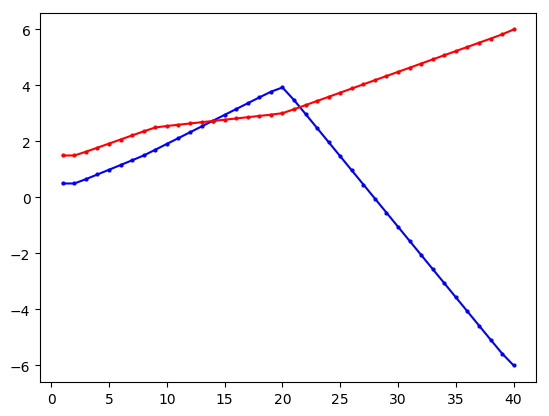

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327cf4ad0>

In [149]:
plot( linspace(1,40,40), xopt[1,:], "b.-", markersize=4 )
plot( linspace(1,40,40), xopt[2,:], "r.-", markersize=4 )

In [150]:
vopt = getvalue(v)

2×40 Array{Float64,2}:
 -0.0  0.154536  0.167505  0.168595  …  -0.497185  -0.426502  0.415773
 -0.0  0.133738  0.144961  0.145902      0.150713   0.175471  0.470497

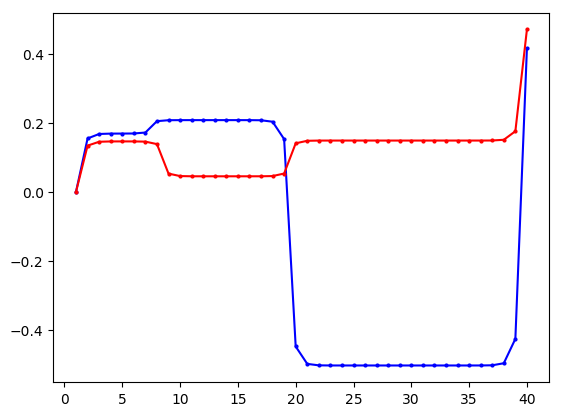

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327eab190>

In [151]:
plot( linspace(1,40,40), vopt[1,:], "b.-", markersize=4 )
plot( linspace(1,40,40), vopt[2,:], "r.-", markersize=4 )